# Import the required libraries

In [1]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import cv2
import numpy as np
from PIL import Image
import glob
import os
from skimage import measure
from scipy import ndimage
from tqdm import tqdm

# Config

In [2]:
path = 'mini_testdatensatz'
min_overlap_percentage = 99
default_ratio = 2.6
min_pixel = 5000
max_pixel = 20000

# Check the segmentation folder

In [3]:
if not os.path.exists(os.path.join(path,'segmentation_images')):
    os.mkdir(os.path.join(path,'segmentation_images'))

filelist = [ f for f in os.listdir(os.path.join(path,'segmentation_images'))]
for f in filelist:
    os.remove(os.path.join(path,'segmentation_images', f))

# Load the model

In [4]:
sam = sam_model_registry["default"](checkpoint="sam_vit_h_4b8939.pth")
mask_generator = SamAutomaticMaskGenerator(sam)

# Path to the images

In [5]:
img_path_list = sorted(glob.glob(path+'/test/*')) # normaly glob.glob(path+'/train/*')

# Functions for the loop

In [6]:
def count_true_values(mask):
    return np.sum(mask)

In [7]:
def find_biggest_contiguous_area(array):
    labels,_ = ndimage.label(array)
    counts = np.bincount(labels.flatten())
    max_label = np.argmax(counts[1:]) + 1
    region = (labels == max_label)
    
    return region

In [8]:
def is_mask_inside(large_mask, small_mask):
    indices = np.where(small_mask)
    return np.all(large_mask[indices])

# Loop 

  0%|          | 0/10 [00:00<?, ?it/s]

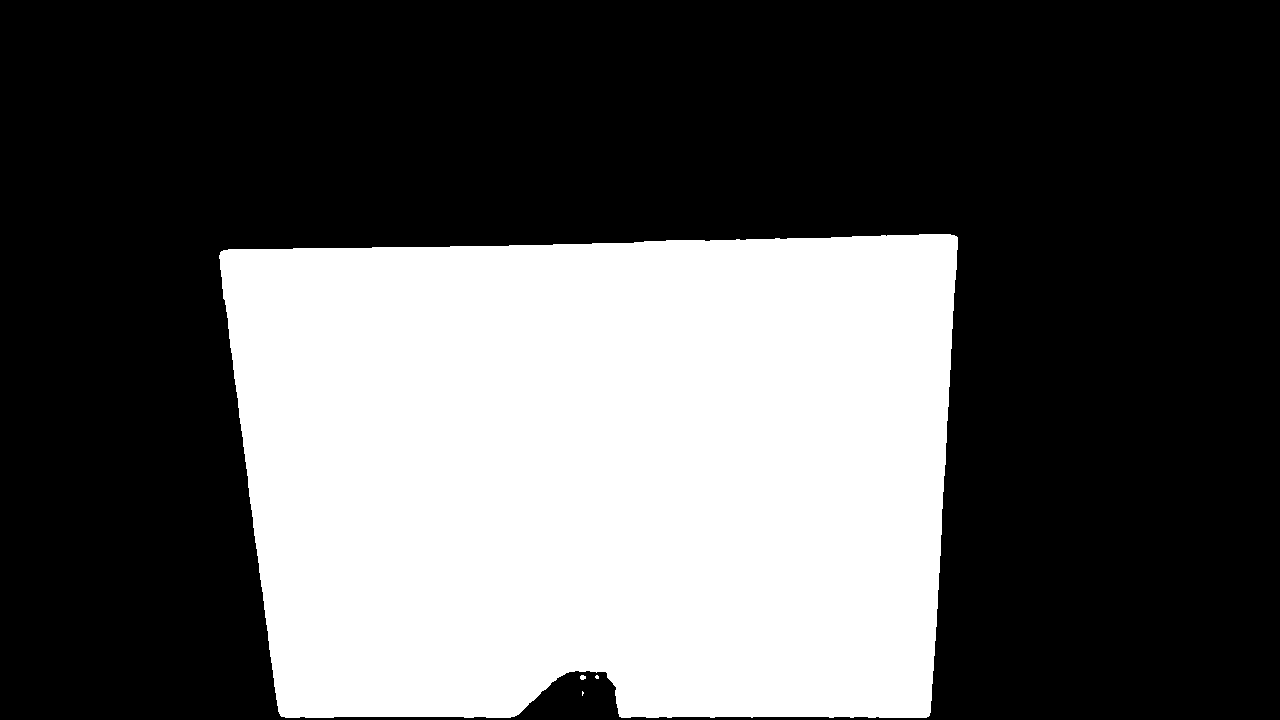

 10%|█         | 1/10 [02:17<20:34, 137.18s/it]

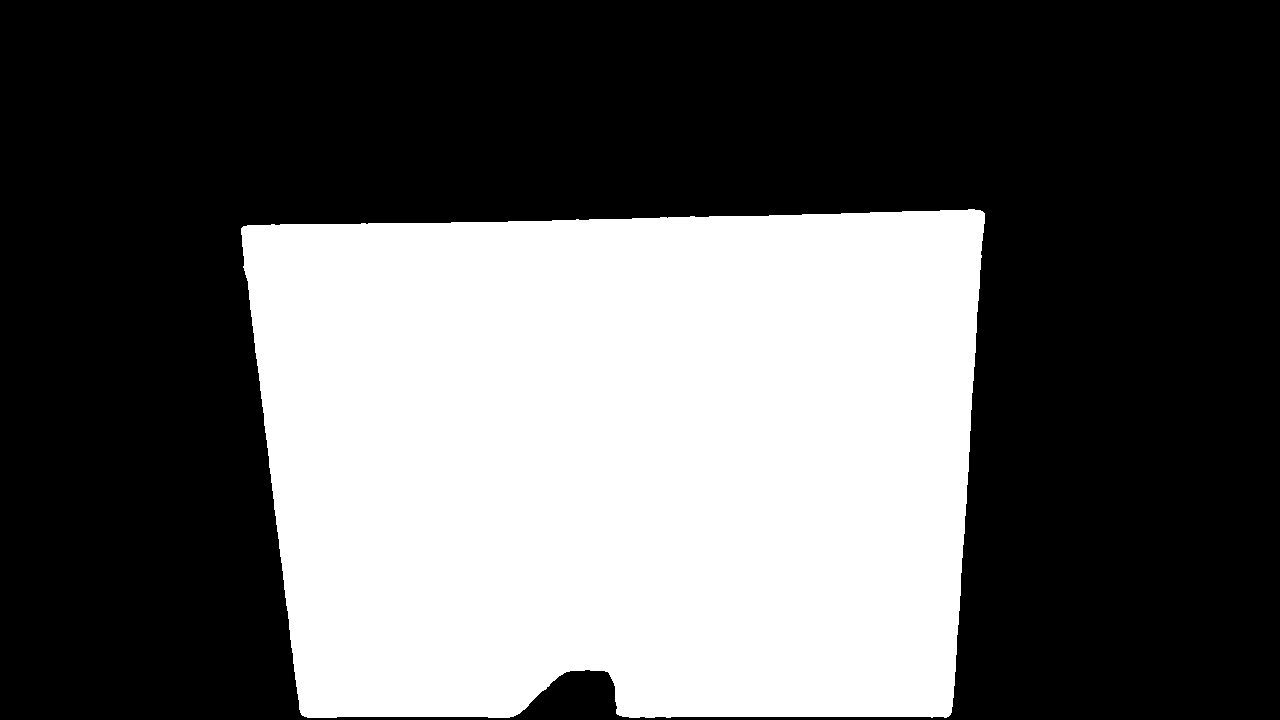

 20%|██        | 2/10 [04:36<18:25, 138.21s/it]

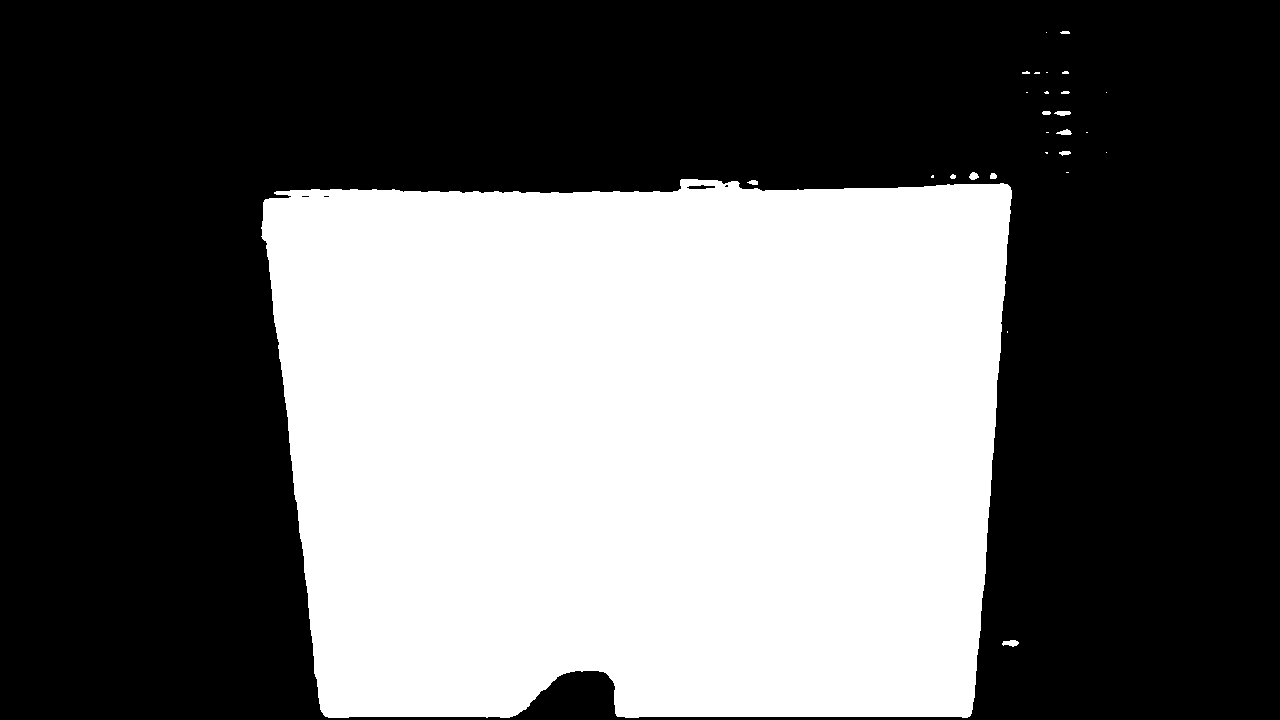

 30%|███       | 3/10 [06:45<15:40, 134.34s/it]

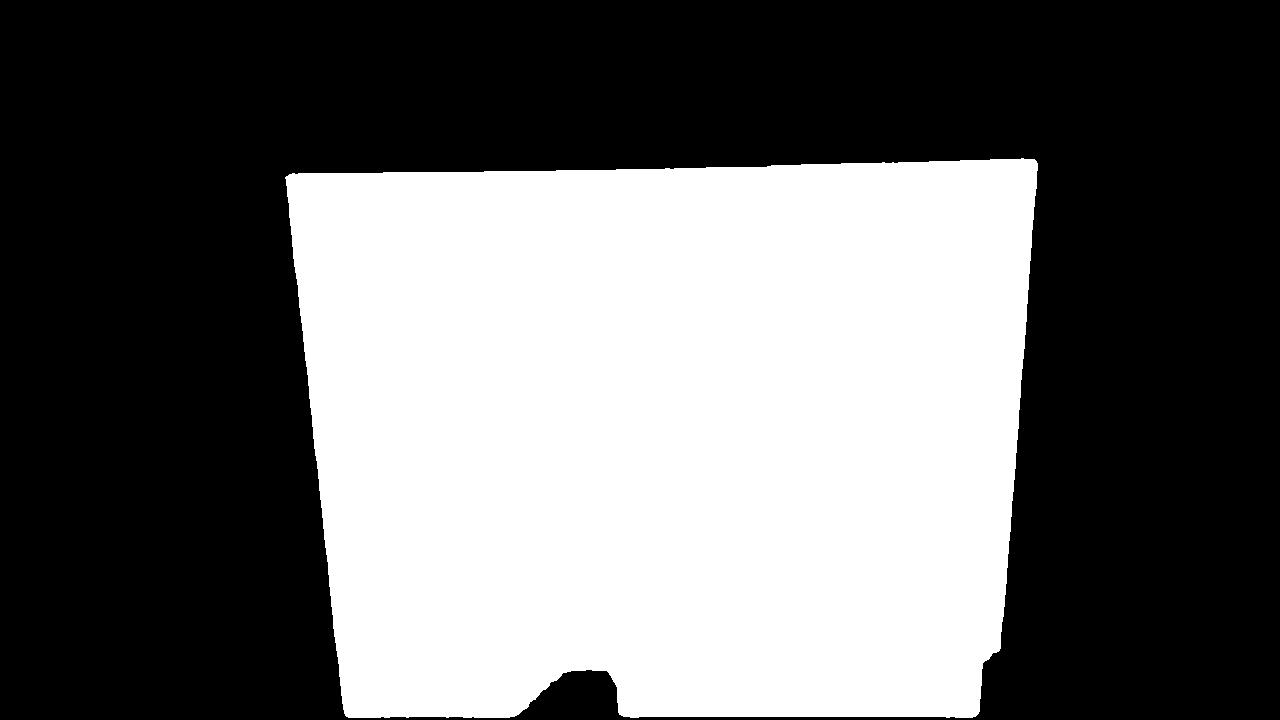

 40%|████      | 4/10 [09:04<13:37, 136.19s/it]

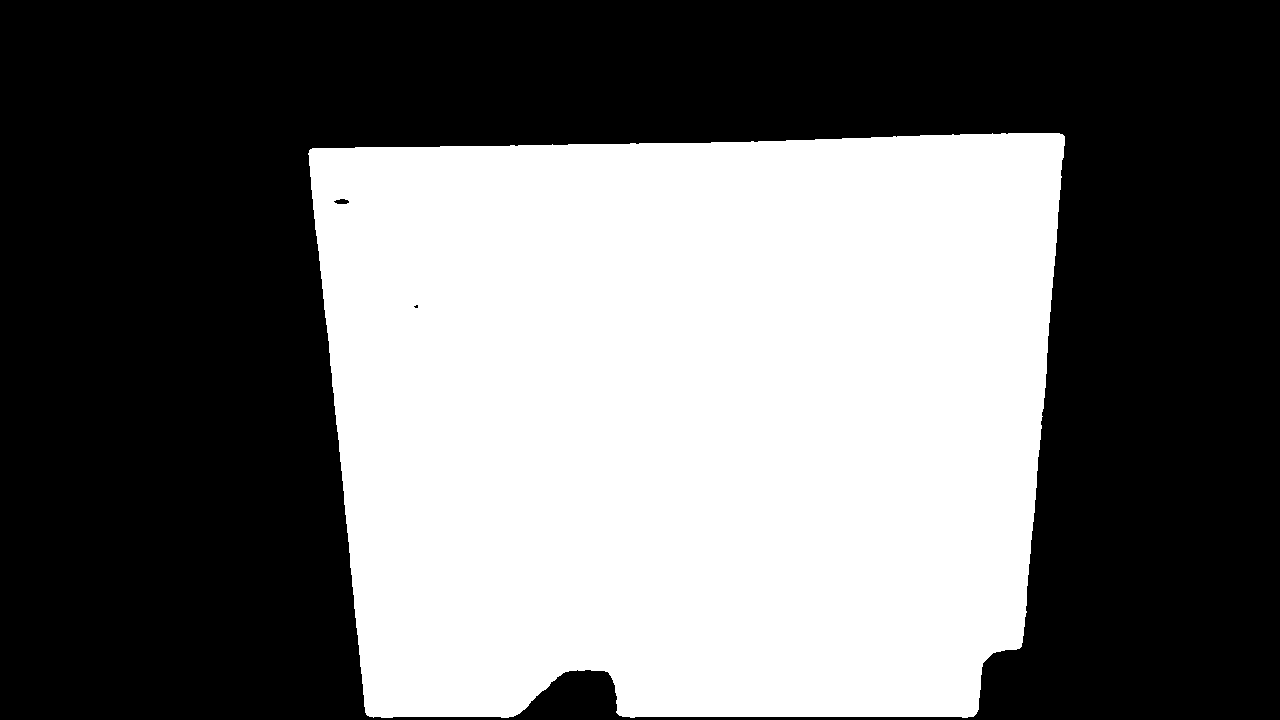

 50%|█████     | 5/10 [11:21<11:22, 136.42s/it]

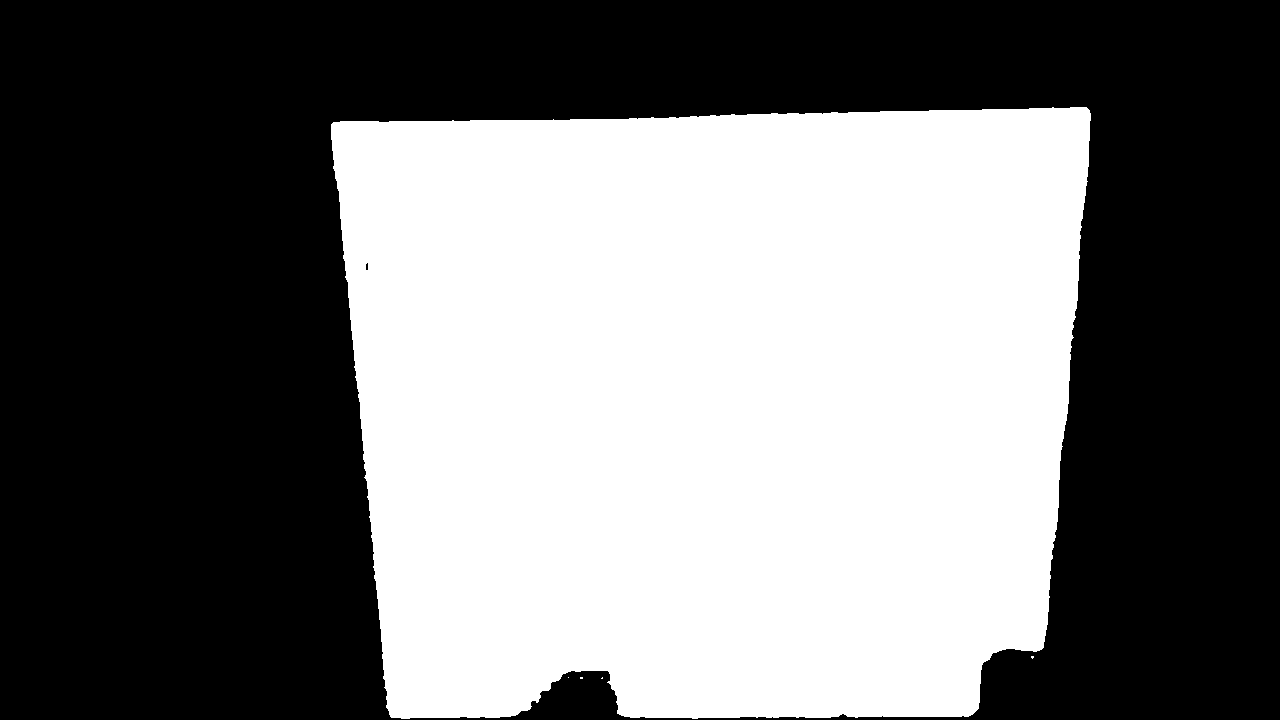

 60%|██████    | 6/10 [13:30<08:55, 133.82s/it]

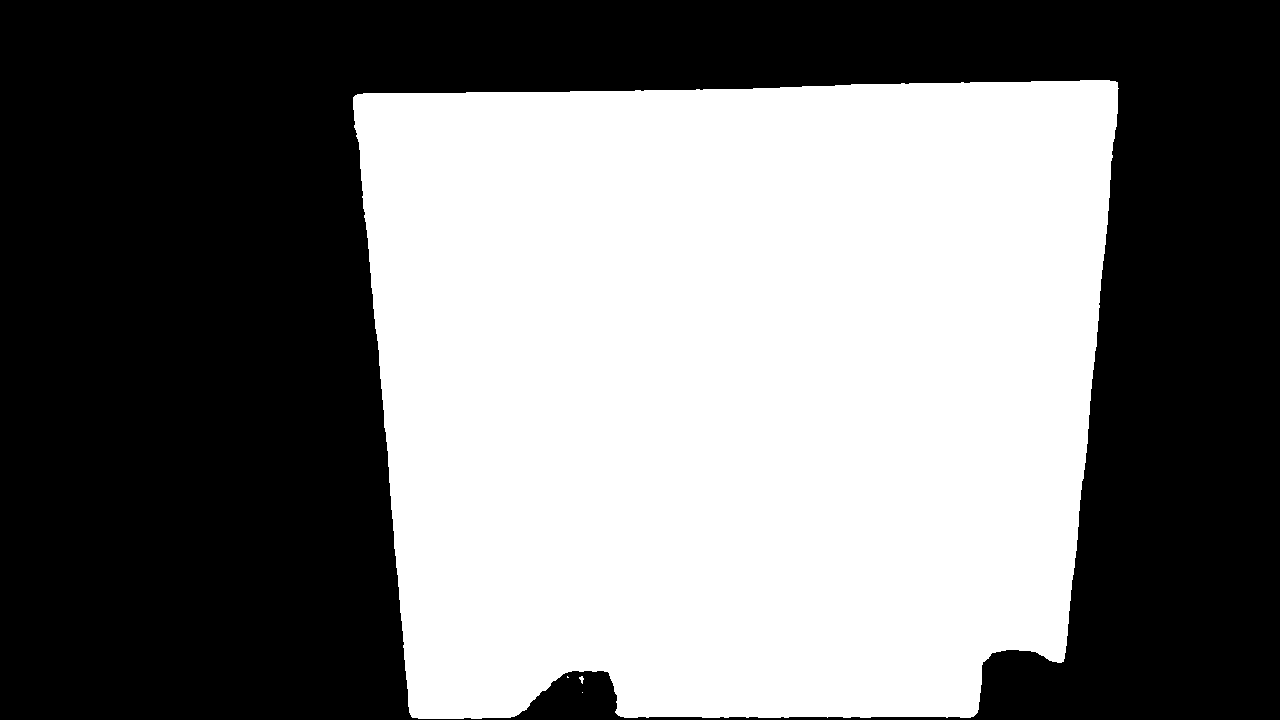

 70%|███████   | 7/10 [15:46<06:44, 134.68s/it]

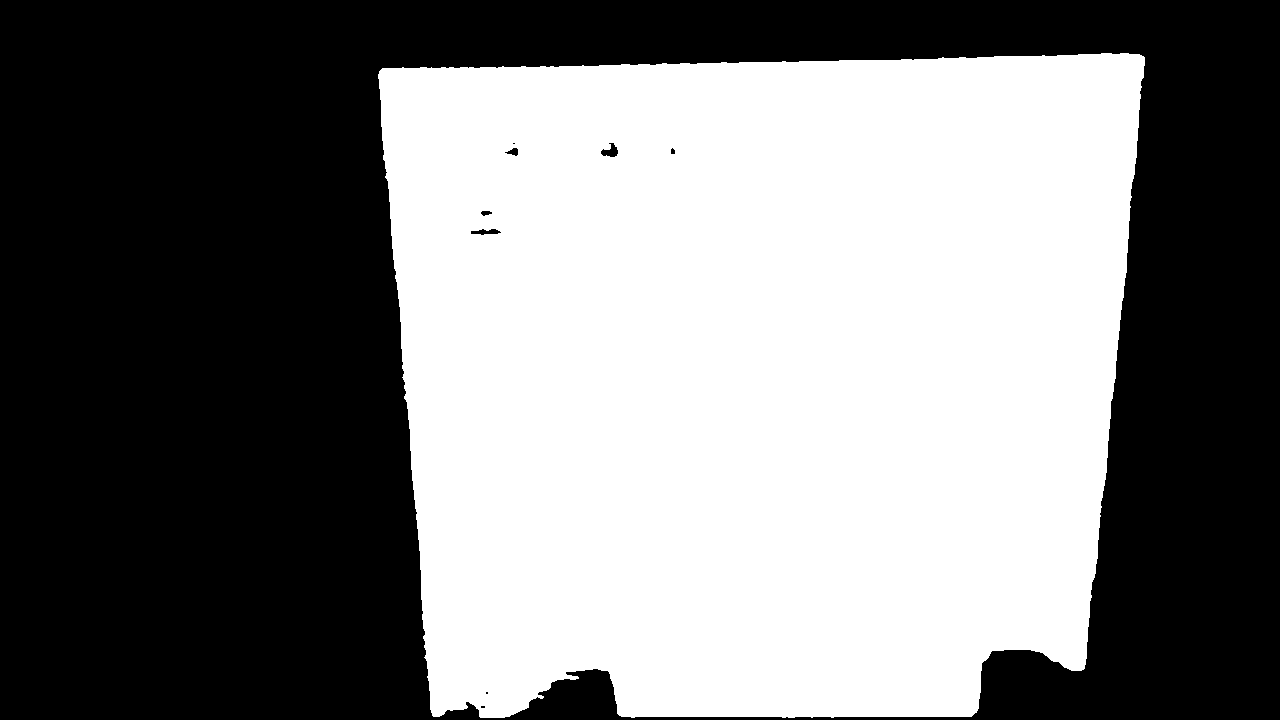

 80%|████████  | 8/10 [17:57<04:26, 133.30s/it]

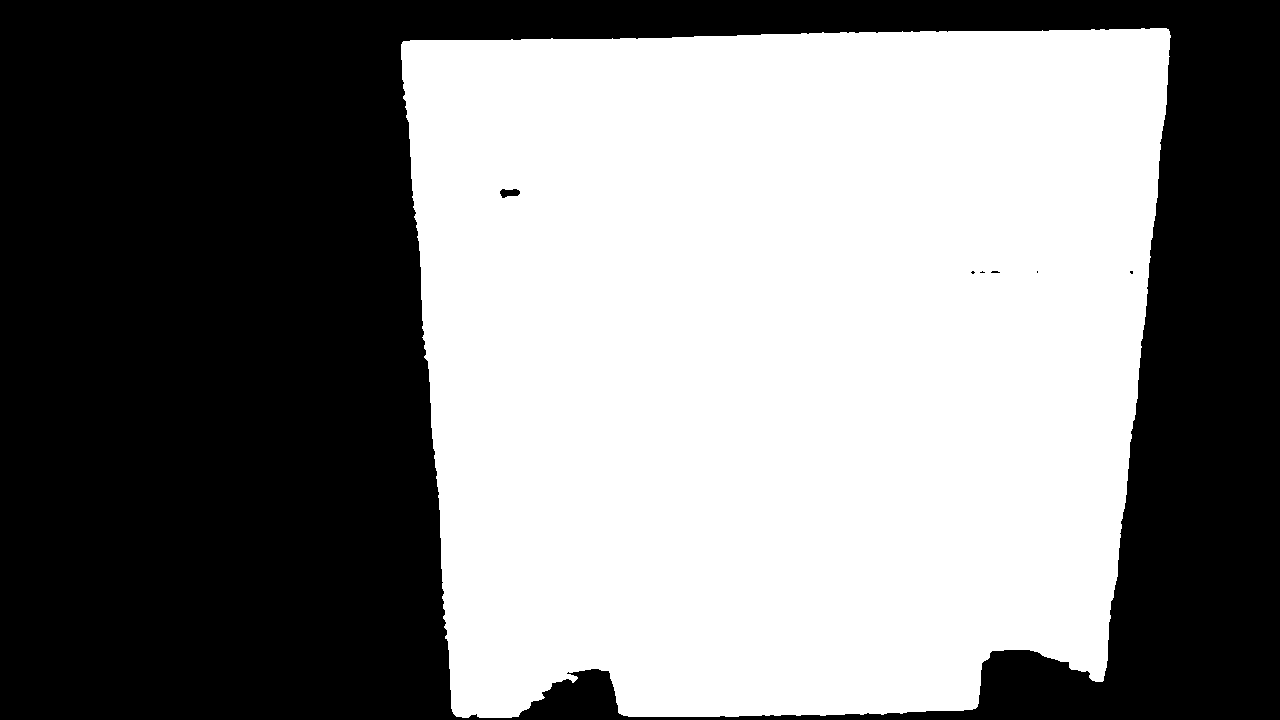

 90%|█████████ | 9/10 [20:24<02:17, 137.53s/it]

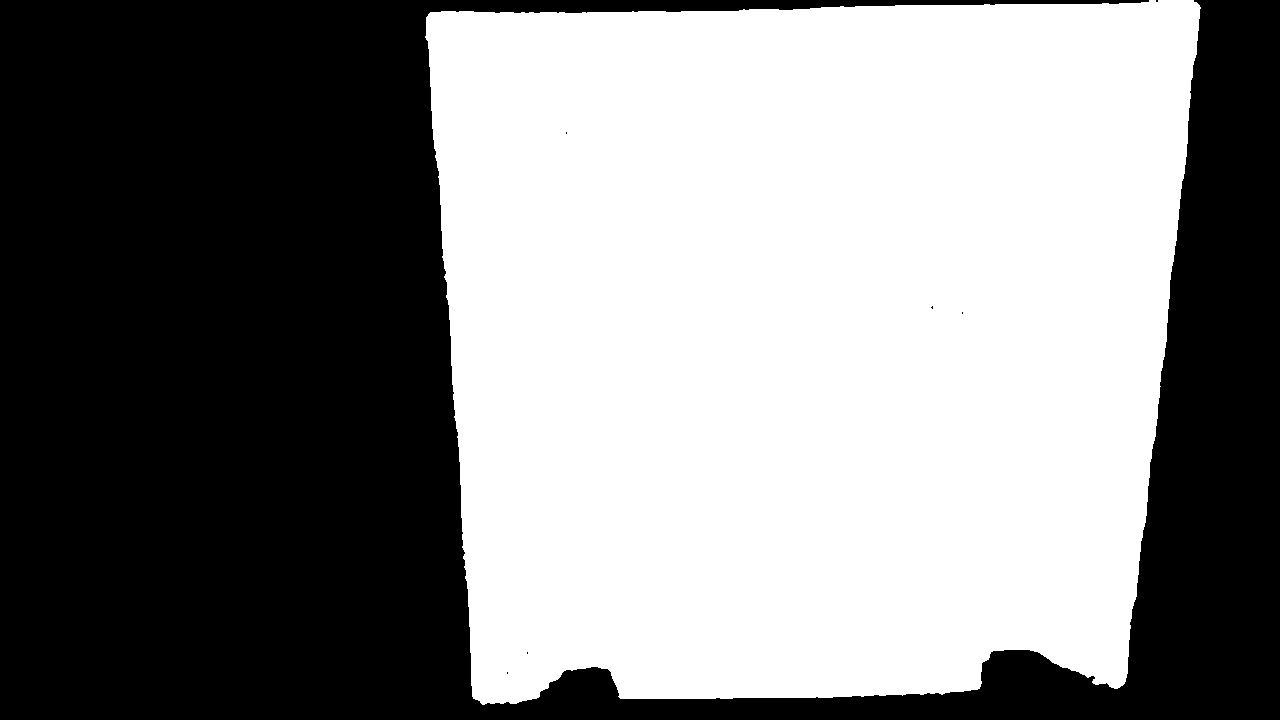

100%|██████████| 10/10 [22:37<00:00, 135.76s/it]


In [9]:
for img_path in tqdm(img_path_list):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(img)
    sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
    intersection = []
    for i in range(4): # 4, because the board should always be in the first 4 masks
        maybe_board_mask = sorted_masks[i]['segmentation']
        nb_intersection = 0
        for j in range(len(sorted_masks)-1):
            if is_mask_inside(maybe_board_mask, sorted_masks[j]['segmentation']):
                nb_intersection += 1
        intersection.append(nb_intersection)
    board_mask = sorted_masks[np.argmax(intersection)]['segmentation']

    inside_masks = []
    for i in range(2, len(sorted_masks)):
        small_mask = sorted_masks[i]['segmentation']
        num_small_mask_true = np.sum(small_mask)
        required_overlap = int(num_small_mask_true * min_overlap_percentage / 100)
        indices = np.where(small_mask)
        num_overlapping_true = np.sum(board_mask[indices])

        if num_overlapping_true >= required_overlap:
            inside_masks.append(small_mask)
    
    inside_masks_sorted = sorted(inside_masks, key=count_true_values, reverse=True)

    ratio = []
    for i in range(len(inside_masks_sorted)-1):

        maybe_plug_mask = inside_masks_sorted[i]
        pixels = count_true_values(maybe_plug_mask)
        if pixels < min_pixel or pixels > max_pixel:
            ratio.append(0)
            continue
        contours = measure.find_contours(maybe_plug_mask, 0.5)
        width = np.max([np.max(contour[:, 1]) for contour in contours])
        height = np.max([np.max(contour[:, 0]) for contour in contours])
        ratio.append(width/height)

    closest_value = min(ratio, key=lambda x: abs(x - default_ratio))
    closest_index = ratio.index(closest_value)
    plug_mask = inside_masks_sorted[closest_index]
    plug_mask = find_biggest_contiguous_area(plug_mask)

    plug_image = Image.fromarray(plug_mask.astype('uint8') * 255, mode='L')
    img_name = img_path.split('/')[-1]
    plug_image.save(path+'/segmentation_images/'+img_name)

